1 Physical GPUs, 1 Logical GPUs
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               5500      
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 20,701
Trainable params: 20,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 3s 243ms/step - loss: 1875053568.0000 -

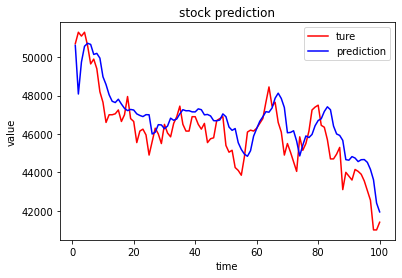

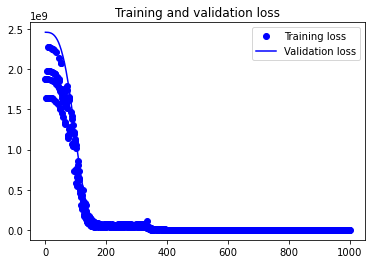

In [3]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

seq_length = 5
x_data_dim = 4
batch_size = 100
min_max_normalization_flag = True

data_dir = '../dataset'
fname = os.path.join(data_dir, 'a_company_stock.csv')
df = pd.read_csv(fname)

dataset = df.copy()
ori_Y=dataset.pop("Close")
ori_X=dataset.copy()

ori_X=ori_X[700:1226] ### 행 700~1225까지 데이터 가져오기
ori_Y=ori_Y[700:1226] ### 행 700~1225까지 데이터 가져오기

X_train, X_test, Y_train, Y_test = train_test_split(ori_X, ori_Y, test_size = 0.2, shuffle = False)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, shuffle = False)

## 데이터의 min , max, mean, std 값 구하기.
dataset_stats = X_train.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
## data normalization
def min_max_norm(x):
    return (x - dataset_stats['min']) / (dataset_stats['max'] - dataset_stats['min'])


def standard_norm(x):
    return (x - dataset_stats['mean']) / dataset_stats['std']


if min_max_normalization_flag == True:
    min_max_norm_train_data = min_max_norm(X_train)
    min_max_norm_val_data = min_max_norm(X_val)
    min_max_norm_test_data = min_max_norm(X_test)

    data_gen_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_train_data.values.tolist(),
                                                                        Y_train.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                        )
    data_gen_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_val_data.values.tolist(),
                                                                       Y_val.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                       )
    data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_test_data.values.tolist(),
                                                                        Y_test.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                        )
else:
    data_gen_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train.values.tolist(),
                                                                         Y_train.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                         )
    data_gen_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_val.values.tolist(), Y_val.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                       )
    data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test.values.tolist(), Y_test.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,stride=1,
                                                                        batch_size=batch_size,
                                                                        start_index=0,reverse=False
                                                                        )


input_Layer = tf.keras.layers.Input(shape=(seq_length, x_data_dim))
x= tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50,activation='tanh', recurrent_dropout=0.2, return_sequences=True))(input_Layer)
x= tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50,activation='tanh'))(input_Layer)
x=tf.keras.layers.Dense(100,activation='relu')(x)
x=tf.keras.layers.Dense(50,activation='relu')(x)
Out_Layer=tf.keras.layers.Dense(1,activation='linear')(x)
model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()

loss_function=tf.keras.losses.mean_squared_error
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.mean_absolute_error
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model.fit(
      data_gen_train,
      validation_data=data_gen_val,
      steps_per_epoch=len(X_train)//batch_size,
      epochs=1000,
     validation_freq=1
)
print(model.evaluate(data_gen_test))

#loss_function =
#optimize =
#metric =
#model.compile()
#
#history = model.fit(
#
#)
#
print(model.evaluate(data_gen_test))

test_data_X, test_data_Y = data_gen_test[0]
prediction_Y = model.predict(test_data_X).flatten()
Y_test = test_data_Y.flatten()

visual_y = []
visual_pre_y = []
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))
    visual_y.append(label)
    visual_pre_y.append(prediction)

time = range(1, len(visual_y) + 1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


